<a href="https://colab.research.google.com/github/gibsonx/tf_skeleton/blob/master/tf_keypoint_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/gibsonx/tf_skeleton.git

fatal: destination path 'tf_skeleton' already exists and is not an empty directory.


In [ ]:
!pip install -r /content/tf_skeleton/requirements.txt > /dev/null

In [2]:
from pycocotools.coco import COCO
import numpy as np
import os.path
from typing import Any, Callable, List, Optional, Tuple
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, json, cv2, numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import Sequential

from keras.layers import (
    Flatten,
    Dense,
    Dropout,
    Conv2D,
    LeakyReLU,
    BatchNormalization,
    MaxPool2D,
)
from imgaug import augmenters as iaa
import imgaug as ia
import imageio

from imgaug.augmentables.kps import Keypoint, KeypointsOnImage

In [4]:
img_dir="/content/drive/MyDrive/Dataset/aspine202030604/images"
annotations_file="/content/drive/MyDrive/Dataset/aspine202030604/annotations/person_keypoints_Train.json"

In [5]:
coco=COCO(annotations_file)
imgIds = coco.getImgIds()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [6]:
kps_metrix = []
image_list = []

for id in imgIds:
    img = coco.loadImgs(id)[0]
    imgPath = os.path.join(img_dir,img['file_name'])
    image_list.append(Image.open(imgPath))

    # load annotations
    ann=coco.loadAnns(coco.getAnnIds(imgIds=img['id']))
    keypoints_original = [[list(a) for a in zip(*[iter(ann[0]['keypoints'])]*3)]]
    kps_row = []
    for kp in keypoints_original:
        for el in kp:
            kps_row.extend(el[0:2])

    kps_metrix.append(kps_row)

df = pd.DataFrame(kps_metrix)

image_array_list = [np.array(img) for img in image_list]
df['image'] = image_array_list


In [ ]:
keypoints_classes_ids2names = {0: '1', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: '9', 9: '10', 10: '11', 11: '12', 12: '13', 13: '14', 14: '15', 15: '16'}

def CoupeToInt(coupe: List[float]) -> List[int]:
    return list(map(int, coupe))

def visualize(array, keypoints):

    # image = Image.fromarray(array)

    open_cv_image = np.array(array)
    image = open_cv_image[:, :, ::-1].copy()
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    converted_keypoints = [CoupeToInt(list(a)) for a in zip(*[iter(keypoints)]*2)]

    for idx, kp in enumerate(converted_keypoints):
        image = cv2.putText(image.copy(), "" + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_PLAIN, 2, (32,253,0), 3, cv2.LINE_AA)
        image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), 10)

    plt.figure(figsize=(25,25))
    plt.imshow(image)
    plt.show()

In [7]:
rand_number = np.random.randint(0,len(imgIds))
simple_row = df.iloc[rand_number]
image = simple_row['image']
annotations = simple_row[:31]

Keypoint 0: (381.59000000, 1479.18000000) -> (180.48175049, 717.17822266)
Keypoint 1: (822.96000000, 1466.55000000) -> (389.23785400, 711.05456543)
Keypoint 2: (269.86000000, 1598.89000000) -> (127.63648224, 775.21942139)
Keypoint 3: (924.45000000, 1598.47000000) -> (437.23986816, 775.01574707)
Keypoint 4: (508.79000000, 1585.66000000) -> (240.64392090, 768.80487061)
Keypoint 5: (688.60000000, 1587.67000000) -> (325.68914795, 769.77941895)
Keypoint 6: (445.94000000, 1537.25000000) -> (210.91755676, 745.33331299)
Keypoint 7: (752.74000000, 1535.92000000) -> (356.02566528, 744.68847656)
Keypoint 8: (598.74000000, 1583.28000000) -> (283.18783569, 767.65093994)
Keypoint 9: (386.69000000, 1802.44000000) -> (182.89392090, 873.91027832)
Keypoint 10: (817.09000000, 1791.10000000) -> (386.46151733, 868.41210938)
Keypoint 11: (413.02000000, 1978.37000000) -> (195.34729004, 959.20971680)
Keypoint 12: (806.28000000, 1957.20000000) -> (381.34863281, 948.94543457)
Keypoint 13: (551.15000000, 1442.49

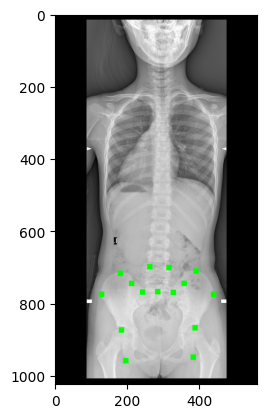

In [10]:
open_cv_image = np.array(image)
converted_keypoints = [list(a) for a in zip(*[iter(annotations)]*2)]

kps = [Keypoint(x=coodination[0], y=coodination[1]) for coodination in converted_keypoints ]
kpsoi = KeypointsOnImage(kps, shape=open_cv_image.shape)

image_with_kps = kpsoi.draw_on_image(open_cv_image, size=15)

ia.seed(1)

seq = iaa.Sequential([
    iaa.Resize({"height": 1024, "width": 560})
])

image_aug, kpsoi_aug = seq(image=image, keypoints=kpsoi)

for i in range(len(kpsoi.keypoints)):
    before = kpsoi.keypoints[i]
    after = kpsoi_aug.keypoints[i]
    print("Keypoint %d: (%.8f, %.8f) -> (%.8f, %.8f)" % (
        i, before.x, before.y, after.x, after.y)
    )
image_after = kpsoi_aug.draw_on_image(image_aug, size=15)

plt.imshow(image_after )

In [ ]:
class DataGenerator(keras.utils.all_utils.Sequence):

  def __init__(self, file_name, rows_per_batch=50, shuffle=False):
      self.rows_per_batch = rows_per_batch
      self.shuffle = shuffle
      self.file_name = file_name
      self.on_epoch_end()
      reader = csv.reader(open(self.file_name, 'r'))
      self.lines = list(reader)

  def __len__(self):
      return len(self.lines) // self.rows_per_batch

  def __getitem__(self, index):
      skip_rows = index * self.rows_per_batch
      nrows = (index + 1) * self.rows_per_batch
      X, y = self.__data_generation(self.folder_name, self.file_name, skip_rows, nrows)

      return X, y

  def on_epoch_end(self):
      if self.shuffle == True:
          np.random.shuffle(self.indexes)

  def __data_generation(self, file_name, skip_rows, nrows, config_file):

      df = pd.read_csv(file_name, header=None, skiprows=skip_rows, nrows=nrows)

      < do some data processing here >

      return X, y

# main program
file_name = <some filename>
rows_per_batch = <some number>

a = DataGenerator(file_name, rows_per_batch, shuffle=False)
b = DataGenerator(file_name, rows_per_batch, shuffle=False)

# Train model on dataset
model.fit_generator(generator=a,
                  validation_data=b,
                  use_multiprocessing=False,
                  shuffle=False,
                  epochs=10,
                  workers=6)

In [ ]:
# Building a CNN model using Sequential API
model = Sequential([
    Conv2D(1, (5, 5), padding='same', use_bias=False, input_shape=(2112, 1184, 3)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),

    # Conv2D(32, (4, 4), padding='same', use_bias=False),
    # LeakyReLU(alpha=0.1),
    # BatchNormalization(),
    # MaxPool2D(pool_size=(2, 2)),

    # Conv2D(64, (3, 3), padding='same', use_bias=False),
    # LeakyReLU(alpha=0.1),
    # BatchNormalization(),
    # MaxPool2D(pool_size=(2, 2)),

    # Conv2D(128, (2, 2), padding='same', use_bias=False),
    # LeakyReLU(alpha=0.1),
    # BatchNormalization(),
    # MaxPool2D(pool_size=(2, 2)),

    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(32)
])

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# initializing few hyper parameters
epochs = 1
batch_size = 128
validation_split = 0.2

In [ ]:

y_train=df.loc[:, df.columns != 'image']

In [ ]:
x_train=np.stack(df['image'])

In [ ]:
x_train=np.stack(df['image'])

In [ ]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mae'])
history=model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split = validation_split)